# **Exploración y análisis de los datos**

En este proyecto, utilizamos conjuntos de datos internacionales obtenidos de Kaggle para entrenar un modelo de detección temprana de plagas y enfermedades en hojas de papa. Los datasets seleccionados contienen imágenes bien etiquetadas que representan diversas enfermedades y hojas saludables:

>https://www.kaggle.com/datasets/shahadhossin567r7455/potato-leaf-disease-dataset

>https://www.kaggle.com/datasets/nirmalsankalana/potato-leaf-disease-dataset

Estos datos provienen de cultivos en regiones fuera de Perú, lo que los convierte en una fuente valiosa para la etapa inicial de entrenamiento del modelo. En lugar de utilizar modelos preentrenados, construiremos y entrenaremos un modelo de redes neuronales convolucionales (CNN) completamente nuevo a partir de estos datos internacionales. Este enfoque nos permitirá crear un modelo base robusto, entrenado sobre un conjunto diverso de enfermedades que afectan a la papa en otros países.

Posteriormente, aplicaremos transferencia de aprendizaje utilizando datos locales de Perú, específicamente de la región de Cusco, para ajustar el modelo. Esta etapa permitirá que el modelo sea más preciso y relevante para las condiciones locales, donde las plagas y enfermedades pueden variar en función de las características del entorno y de los cultivos de papa nativa altoandina.

El objetivo es crear una solución que inicialmente se entrene con datos externos, pero que se ajuste gradualmente para reflejar las particularidades de los cultivos en Perú, mejorando así la detección temprana de plagas y enfermedades en las comunidades altoandinas de Cusco.

### Librerias 

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
import shutil
from tqdm import tqdm
from pathlib import Path

### Rutas de la data 

In [1]:
data_dir = '../data/raw/Potato Leaf Disease'
data_dir2 = '../data/raw/Potato Leaf Disease Dataset in Uncontrolled Environment'

#### Cargar y mostrar imagenes 

In [14]:
# Función para cargar y mostrar  imágenes de cada categoría 
def show_sample_images_pil(data_dir, categories, num_samples=5):
    for category in categories:
        # Obtener la ruta completa de la carpeta de la categoría
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)[:num_samples]  

        print(f"Mostrando imágenes de la categoría: {category}")
        
        # Mostrar las imágenes
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
        for i, img_file in enumerate(images):
            img_path = os.path.join(category_path, img_file)

            try:
                img = Image.open(img_path)  # Cargar la imagen usando PIL
                axes[i].imshow(img)
                axes[i].set_title(f"{category} {i+1}")
                axes[i].axis('off')
            except Exception as e:
                print(f"Error al cargar la imagen: {img_path}. Error: {e}")
                axes[i].axis('off')

        plt.show()

In [15]:
# Definir las categorías en ambas carpetas
categories1 = os.listdir(data_dir)
categories2 = os.listdir(data_dir2)

#### Imágenes del primer dataset

Mostrando imágenes de la categoría: Early Blight


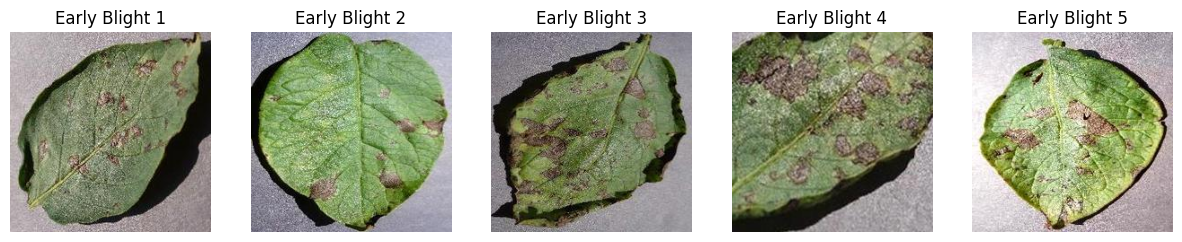

Mostrando imágenes de la categoría: Fungal Diseases


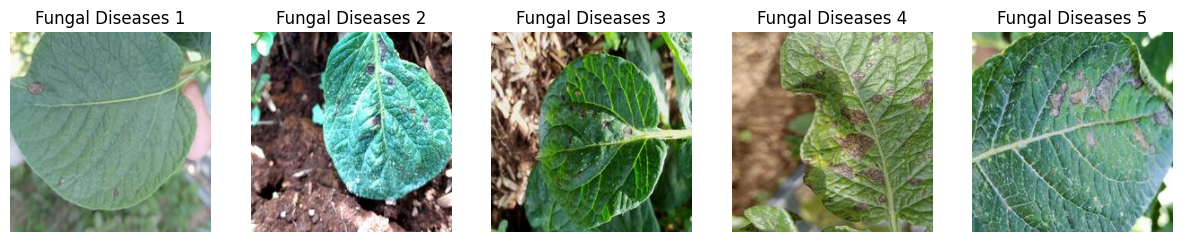

Mostrando imágenes de la categoría: Healthy


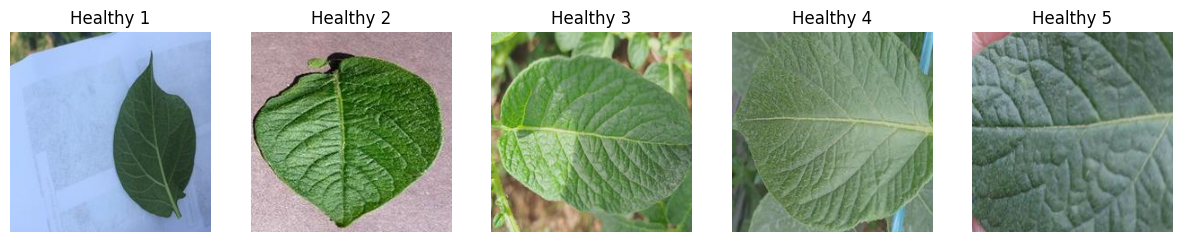

Mostrando imágenes de la categoría: Late Blight


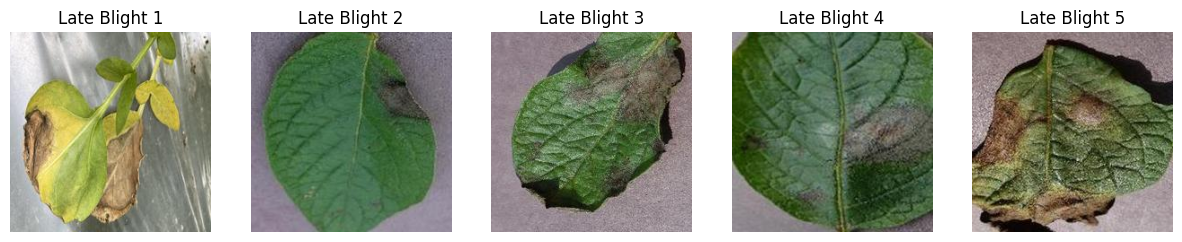

Mostrando imágenes de la categoría: Plant Pests


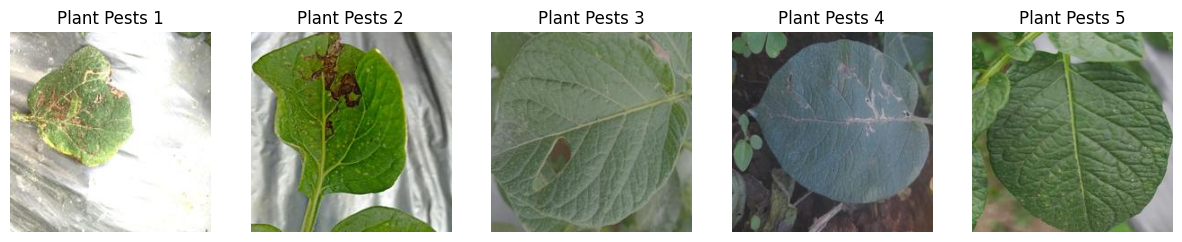

Mostrando imágenes de la categoría: Potato Cyst Nematode


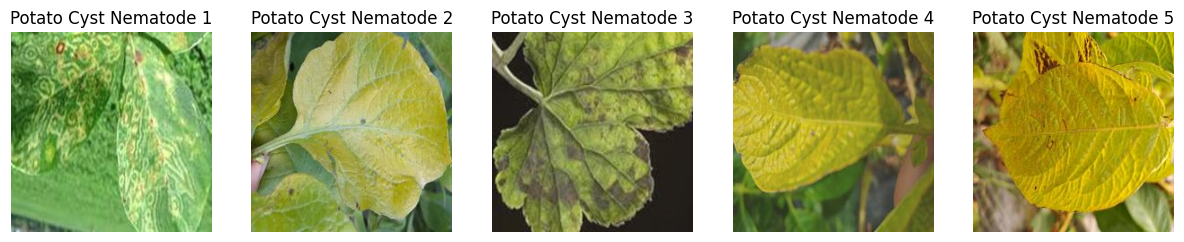

Mostrando imágenes de la categoría: Potato Virus


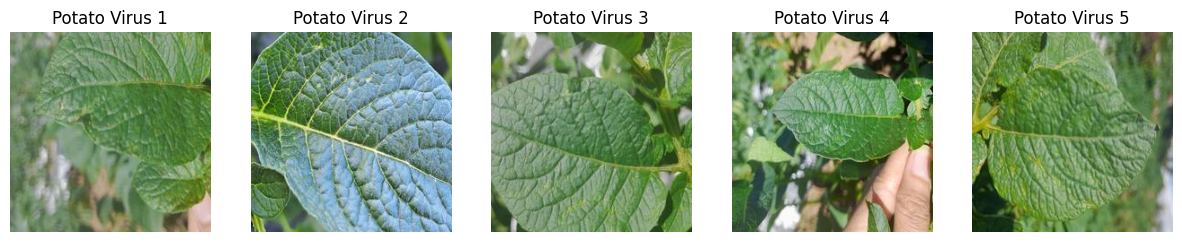

In [16]:
# Mostrar imágenes de la primera carpeta
show_sample_images_pil(data_dir, categories1)

#### Imágenes dele segundo dataset

Mostrando imágenes de la categoría: Bacteria


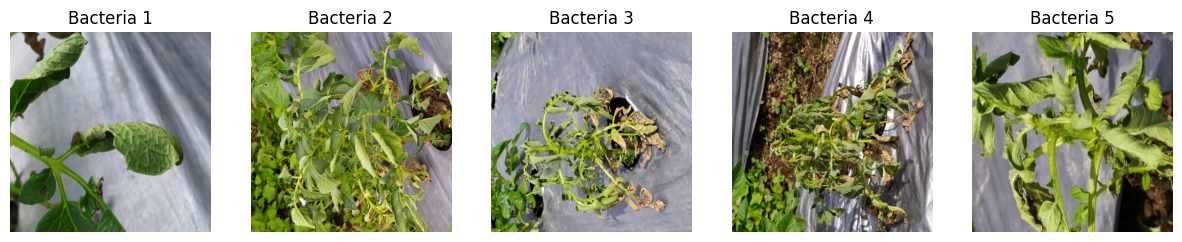

Mostrando imágenes de la categoría: Fungi


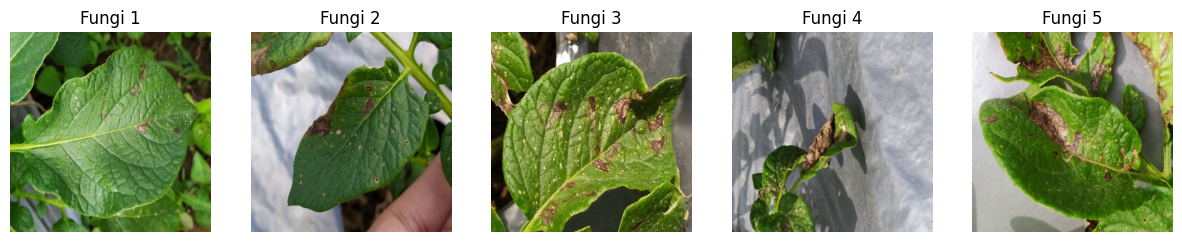

Mostrando imágenes de la categoría: Healthy


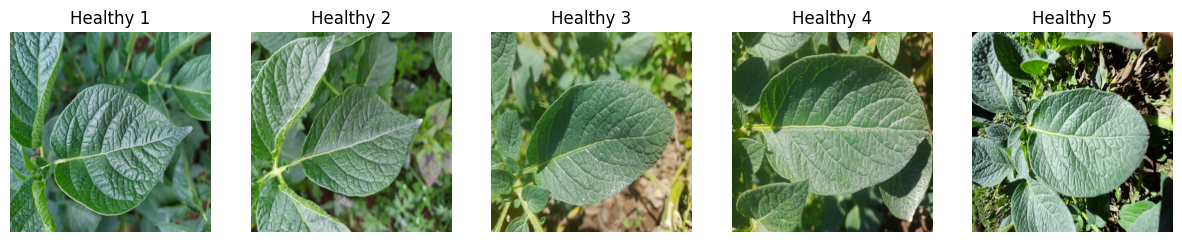

Mostrando imágenes de la categoría: Nematode


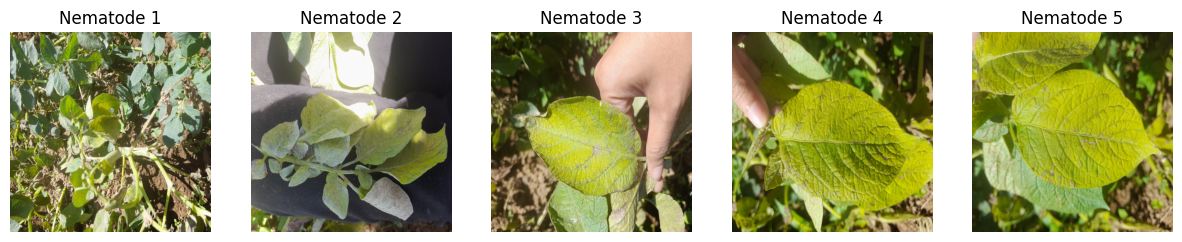

Mostrando imágenes de la categoría: Pest


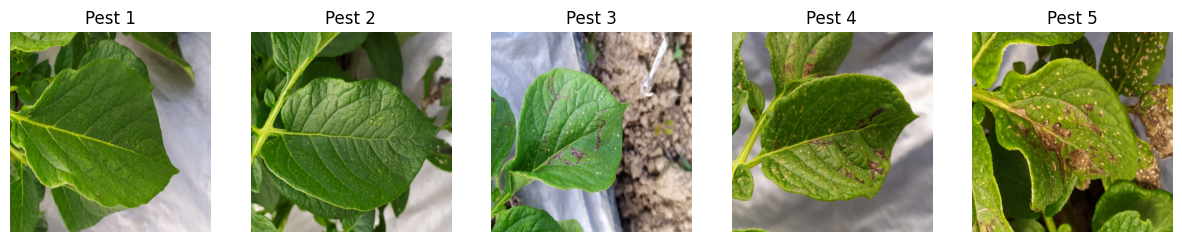

Mostrando imágenes de la categoría: Phytopthora


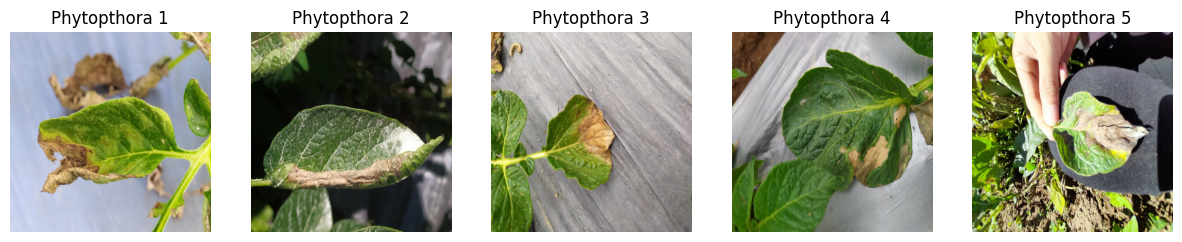

Mostrando imágenes de la categoría: Virus


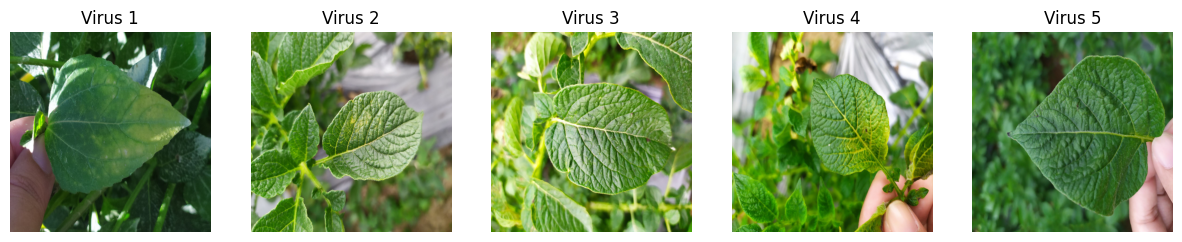

In [27]:
# Mostrar imágenes de la segunda carpeta
show_sample_images_pil(data_dir2, categories2)

#### Obtener  estadisticas del dataset

In [28]:
def count_images_in_categories(data_dir):
    # Listar todas las categorías
    categories = os.listdir(data_dir)
    category_counts = {}
    
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            # Contar los archivos en cada subcarpeta
            count = len(os.listdir(category_path))
            category_counts[category] = count
    
    # Convertir el diccionario en un DataFrame
    df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])
    return df


#### dataset1

In [29]:
data = count_images_in_categories(data_dir)
data

Category  Count
0          Early Blight    500
1       Fungal Diseases    500
2               Healthy    500
3           Late Blight    500
4           Plant Pests    500
5  Potato Cyst Nematode    500
6          Potato Virus    500

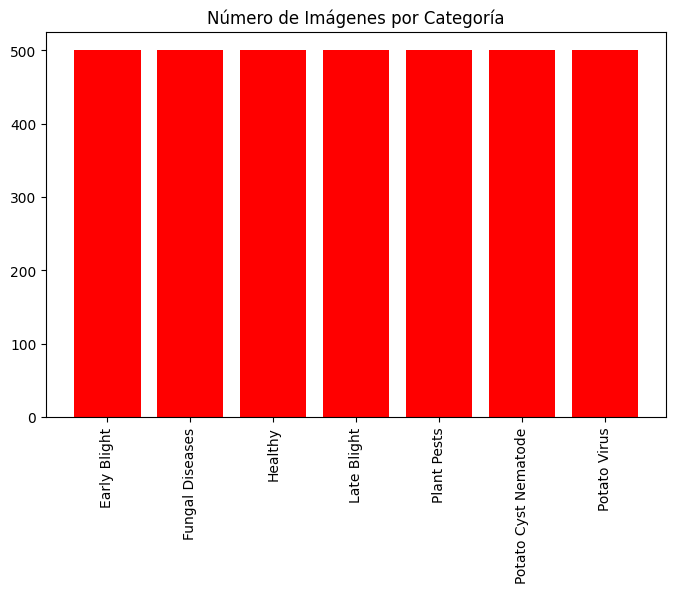

In [30]:
plt.figure(figsize= (8,5))
plt.bar(data['Category'], data['Count'], color ='red')
plt.title('Número de Imágenes por Categoría')
plt.xticks(rotation=90)
plt.show()

##### dataset2

In [31]:
data2 = count_images_in_categories(data_dir2)
data2

Category  Count
0     Bacteria    569
1        Fungi    748
2      Healthy    201
3     Nematode     68
4         Pest    611
5  Phytopthora    347
6        Virus    532

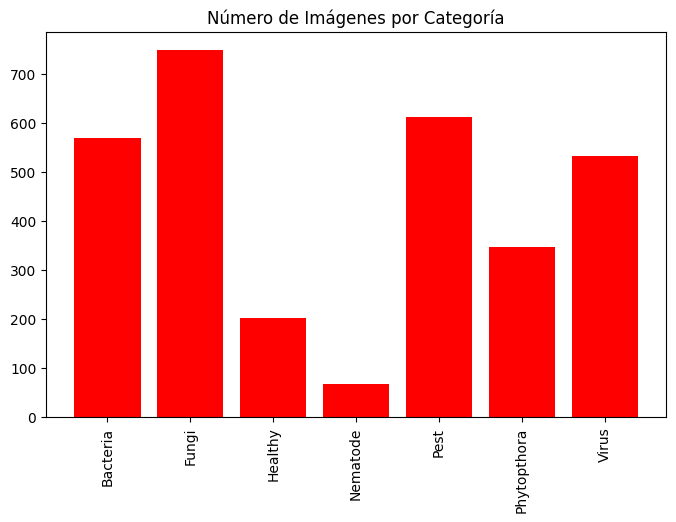

In [32]:
plt.figure(figsize= (8,5))
plt.bar(data2['Category'], data2['Count'], color ='red')
plt.title('Número de Imágenes por Categoría')
plt.xticks(rotation=90)
plt.show()

# Agrupacion de imagenes para cada categoria

### Salud
- Hojas de papa sin signos visibles de enfermedad o daño.
- Apariencia normal, sin manchas, decoloraciones ni deformaciones.
- Color verde uniforme, textura suave, y forma que corresponde a la variedad de papa.

### Tizón Tardío (*Phytophthora infestans*)
- Incluye imágenes etiquetadas como "Tizón tardío" y "Phytophthora"
- Causado por *Phytophthora infestans*, un oomiceto que afecta principalmente en condiciones húmedas.
- **Síntomas**: Manchas oscuras irregulares en las hojas, a menudo rodeadas por un borde amarillento. En ambientes húmedos, se puede observar moho blanco en el envés de las hojas.

### Tizón Temprano (*Alternaria solani*)
- Causado por el hongo *Alternaria solani*.
- **Síntomas**: Lesiones marrones oscuras con patrones de anillos concéntricos, principalmente en las hojas más viejas. Las hojas afectadas pueden amarillear y caer prematuramente.

### Enfermedades Fúngicas
- Incluye varias infecciones por hongos, excepto el tizón tardío y el tizón temprano.
- **Síntomas**: Manchas en las hojas, decoloraciones irregulares o crecimientos anormales.

### Enfermedades Bacterianas
- Causadas por diversas bacterias que infectan la papa.
- **Síntomas**: Manchas acuosas que se tornan marrones, y en casos severos, podredumbre en las hojas o tallos.

### Enfermedades Virales
- Provocadas por distintos virus que afectan las plantas de papa.
- **Síntomas**: Pueden incluir patrones de mosaico (decoloraciones irregulares), enrollamiento de hojas, enanismo o deformación de las mismas.

### Daños por Plagas
- Causados por insectos u otros organismos que se alimentan de las hojas de la papa.
- **Síntomas**: Agujeros en las hojas, bordes dañados o masticados, galerías o túneles dentro de las hojas.

### Daños por Nematodos
- Causados por pequeños gusanos que afectan las raíces, pero con síntomas visibles en las hojas.
- **Síntomas**: Amarillamiento general de las hojas, crecimiento reducido de la planta, y marchitez en condiciones de estrés hídrico.


In [33]:
# Función para mapear categorías originales a las nuevas 8 categorías
def map_category(category):
    category = category.lower()  # Convertir a minúsculas
    if category in ['healthy']:
        return 'Salud'
    elif category in ['late blight', 'phytopthora']:
        return 'Tizón tardío (Phytophthora)'
    elif category in ['early blight']:
        return 'Tizón temprano'
    elif category in ['fungal diseases', 'fungi']:
        return 'Enfermedades fúngicas'
    elif category in ['bacteria']:
        return 'Enfermedades bacterianas'
    elif category in ['potato virus', 'virus']:
        return 'Enfermedades virales'
    elif category in ['plant pests', 'pest']:
        return 'Daños por plagas'
    elif category in ['potato cyst nematode', 'nematode']:
        return 'Daños por nematodos'
    else:
        return 'Otros'

def copy_with_unique_name(src, dst):
    base, ext = os.path.splitext(dst)
    counter = 1
    while os.path.exists(dst):
        dst = f"{base}_{counter}{ext}"
        counter += 1
    shutil.copy(src, dst)
    
def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))


# Modificar el proceso de copia para usar esta función
def process_images(data_dir, output_dir):
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            new_category = map_category(category)
            new_category_path = os.path.join(output_dir, new_category)
            Path(new_category_path).mkdir(parents=True, exist_ok=True)

            for image in os.listdir(category_path):
                image_path = os.path.join(category_path, image)
                if os.path.isfile(image_path) and is_image_file(image):
                    dest_image_path = os.path.join(new_category_path, image)
                    try:
                        copy_with_unique_name(image_path, dest_image_path)
                    except Exception as e:
                        print(f"Error al copiar la imagen: {image_path}. Error: {e}")

In [34]:
# Rutas de los directorios de origen
data_dir = Path(data_dir )
data_dir2 = Path(data_dir2)


In [35]:
 # Ruta del directorio de destino
output_dir = Path('../data/processed/Potato_Leaf_Categories')

In [36]:

output_dir.mkdir(parents=True, exist_ok=True)

In [37]:
output_dir.mkdir(parents=True, exist_ok=True)

In [38]:
# Procesa ambos conjuntos de datos
process_images(data_dir, output_dir)
process_images(data_dir2, output_dir)

print("Imágenes procesadas y agrupadas correctamente.")

Imágenes procesadas y agrupadas correctamente.


In [39]:
# Contar imágenes en las nuevas categorías
def count_images_in_categories(data_dir):
    category_counts = {}
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            count = len(os.listdir(category_path))
            category_counts[category] = count
    return pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])


#### Resultados de la union del dataset segun el ajuste y las definiciones

In [40]:
final_data1 = count_images_in_categories(output_dir)
final_data1

Category  Count
0          Daños por nematodos    568
1             Daños por plagas   1111
2     Enfermedades bacterianas    569
3        Enfermedades fúngicas   1248
4         Enfermedades virales   1032
5                        Salud    701
6  Tizón tardío (Phytophthora)    847
7               Tizón temprano    500

In [41]:
 # Ruta del directorio que se hizo manualmente
data_manual = Path('../data/processed/manual')

In [54]:
data = count_images_in_categories(data_manual)
data

Category  Count
0          Daños por nematodos    568
1             Daños por plagas   1111
2     Enfermedades bacterianas    569
3        Enfermedades fúngicas   1248
4         Enfermedades virales   1032
5                        Salud    701
6  Tizón tardío (Phytophthora)    847
7               Tizón temprano    500

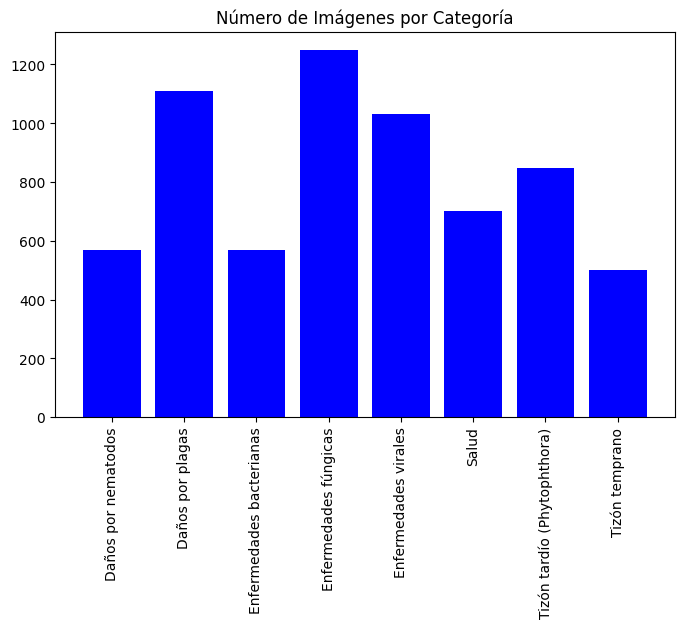

In [56]:
plt.figure(figsize= (8,5))
plt.bar(data ['Category'], data['Count'], color ='blue')
plt.title('Número de Imágenes por Categoría')
plt.xticks(rotation=90)
plt.show()